In [1]:
import matplotlib.pyplot as plt
from scipy.stats import entropy
import skmob
from skmob.measures.individual import real_entropy, uncorrelated_entropy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

formatter = ticker.FormatStrFormatter("%.2f")

In [16]:
#data_un = pd.read_csv("cola_entropy.csv")
data = pd.read_csv("mandagsmagi.csv", index_col=0)

In [17]:
data_un = data.drop_duplicates(subset=["ad_creative_body", "page_id"])

In [3]:
top_labels = (data["top_label"].value_counts()).iloc[:19]  # all labels

# calcu the amount + % for each top
top_percentages = (data["top_label"].value_counts(normalize=True).iloc[:18]) * 100

# Print the counts and percentages in a readable format
print("Stats on top labels:\n")
for label, count, percentage in zip(
    top_labels.index, top_labels.values, top_percentages.values
):
    print(f"{label}: {count} ads ({percentage:.2f}%)")

Stats on top labels:

Call for Action: 353488 ads (76.89%)
Healthcare: 20754 ads (4.51%)
Law and Crime: 17701 ads (3.85%)
Economy: 10691 ads (2.33%)
Climate: 10426 ads (2.27%)
Immigration: 9408 ads (2.05%)
Defense: 8676 ads (1.89%)
Other: 6747 ads (1.47%)
Education and Culture: 5048 ads (1.10%)
Labor and Employment: 4585 ads (1.00%)
Foreign Affair: 4035 ads (0.88%)
Civil Rights: 3213 ads (0.70%)
Agriculture: 1555 ads (0.34%)
Housing: 1192 ads (0.26%)
Transport: 1135 ads (0.25%)
Social Welfare: 1074 ads (0.23%)


In [4]:
# the most 'heavy' ones to proces are Bernie Sanders 124955570892789 and Alexandria Ocasio-Cortez 1316372698453411
top_10_ids = data["page_id"].value_counts().head(10)
print(top_10_ids)

page_id
124955570892789     57326
1316372698453411    55604
38471053686         36480
163148530407080     16046
36872302227         15445
6820348410          12106
97493741436          9096
57495285387          7038
428821014132730      7001
165987503528599      6721
Name: count, dtype: int64


### Entropy code

In [66]:
# Load the dataset
data = pd.read_csv("mandagsmagi.csv")

# Prepare the data
data = data[["page_id", "page_name", "top_label", "ad_creation_time"]]
data["top_label_int"] = pd.factorize(data["top_label"], sort=True)[0] + 1
data["lat"] = 0.0  # Add constant latitude

# Convert to TrajDataFrame
tdf = skmob.TrajDataFrame(
    data,
    latitude="lat",
    longitude="top_label_int",
    datetime="ad_creation_time",
    user_id="page_id",
)

# Sort TrajDataFrame by user ID and datetime
#tdf = tdf.sort_values(by=["_id", "datetime"])

In [67]:
tdf.head(5)

,uid,page_name,top_label,datetime,lng,lat
0,38471053686,Elizabeth Warren,Education and Culture,2020-02-12,7.0,0.0
1,38471053686,Elizabeth Warren,Education and Culture,2020-02-12,7.0,0.0
2,38471053686,Elizabeth Warren,Education and Culture,2020-02-12,7.0,0.0
3,38471053686,Elizabeth Warren,Education and Culture,2020-02-12,7.0,0.0
4,38471053686,Elizabeth Warren,Education and Culture,2020-02-12,7.0,0.0


In [68]:
# Load the dataset
data = pd.read_csv("mandagsmagi.csv")

# Prepare the data
data = data[["page_id", "page_name", "top_label", "ad_creation_time"]]
data["top_label_int"] = pd.factorize(data["top_label"], sort=True)[0] + 1
data["lat"] = 0.0  # Add constant latitude

# Convert to TrajDataFrame
tdf = skmob.TrajDataFrame(
    data,
    latitude="lat",
    longitude="top_label_int",
    datetime="ad_creation_time",
    user_id="page_id",
)

# Sort TrajDataFrame by user ID and datetime
tdf = tdf.sort_values(by=["uid", "datetime"])

# Create an empty DataFrame to collect results
results = pd.DataFrame(columns=["uid", "real_entropy"])

# Process data user by user
unique_users = tdf["uid"].unique()

for user in unique_users:
    # Filter TrajDataFrame for the current user
    user_tdf = tdf[tdf["user_id"] == user]

    # Compute real entropy for the user
    user_entropy = uncorrelated_entropy(user_tdf, normalize=False)

    # Append results to the DataFrame
    results = results.append(
        {"uid": user, "real_entropy": user_entropy}, ignore_index=True
    )

# Save the results to a CSV file
results.to_csv("uncor_uden_batch.csv", index=False, header=True)

print("Processing complete. Results saved to 'un_igen_real_entropy.csv'.")         

KeyError: 'user_id'

In [120]:
data = data[["page_id", "page_name", "top_label", "ad_creation_time"]]

data["top_label_int"] = (
    pd.factorize(data["top_label"], sort=True)[0] + 1
)  # convert Categories to float starting from 1.0 alphabetically

data["lat"] = 0.0  # replacing latitude (mandatory column, giving it a random value)

In [121]:
# TrajDataFrame
tdf = skmob.TrajDataFrame(
    data,
    latitude="lat",
    longitude="top_label_int",
    datetime="ad_creation_time",
    user_id="page_id",
)

In [ ]:
# uncorrelated + real entropy
ue_df = uncorrelated_entropy(tdf, normalize=False)
re_df = real_entropy(tdf)

## Sort away duplicate values and merge uncorrelated values back into dataframe

In [5]:
data_un = data_org.drop_duplicates(subset=["page_id"]) # narrowing down to 518 politicians
data_un = pd.merge(data_un, ue_df, left_on="page_id", right_on="uid", how="left") # mapping uncorrealted values back to dataframe with 518 politicians
data_un = data_un.drop("uid", axis=1)
#data_un = pd.merge(data_un, re_df, left_on="page_id", right_on="uid", how="left")
#data_un = data_un.drop("uid", axis=1)

NameError: name 'ue_df' is not defined

In [5]:
data_entr = pd.read_csv(
    "/Users/sofiepalmuskronborg/Library/CloudStorage/OneDrive-ITU/ITU/Thesis/Data/Data_med_entropy.csv",
    index_col=0,
)

data_entr = data_entr.drop_duplicates(subset=["page_id"])

/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_22664/371406314.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data_entr = pd.read_csv(


## uncorrelated vs real entropy plots

In [213]:
# normalize values for uncor + real entropy 
values_uncor, bins = np.histogram(data_un["uncor entropy"], bins=np.linspace(0, 3.6, 19))
values_uncor = values_uncor / sum(values_uncor)
values_real, bins = np.histogram(data_un["real entropy"], bins=np.linspace(0, 3.6, 19))
values_real = values_real / sum(values_real)

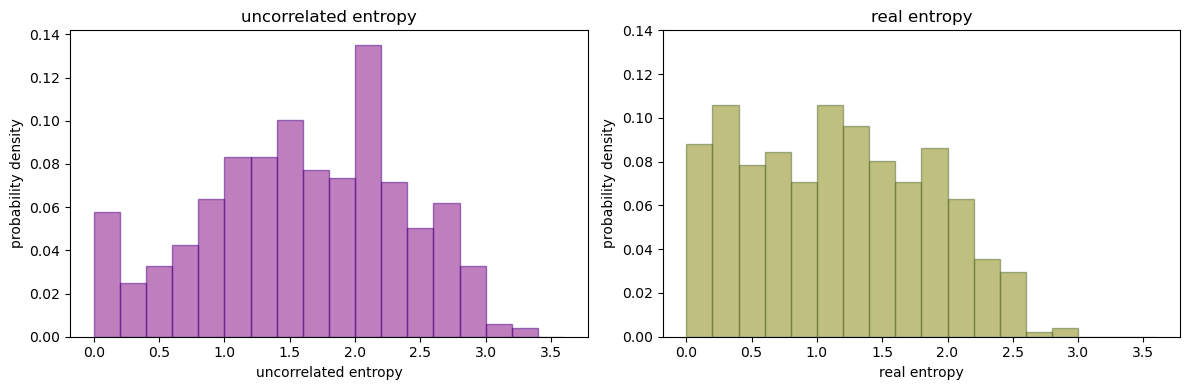

In [211]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].bar(
    bins[:-1],
    values_uncor,
    align="edge",
    width=bins[1] - bins[0],
    alpha=0.5,
    color="purple",
    edgecolor="indigo",
)
axes[0].set_title("uncorrelated entropy")
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")

axes[1].bar(
    bins[:-1],
    values_real,
    align="edge",
    width=bins[1] - bins[0],
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)

max_y = max(max(values_uncor), max(values_uncor))
y_limit = round(max_y + 0.05, 2)

axes[1].set_title("real entropy")
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("real entropy")
axes[1].set_ylim(0, 0.14)
axes[0].yaxis.set_major_formatter(formatter)
axes[1].yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [6]:
data_entr["real_entropy"].describe()

count    516.000000
mean       1.328550
std        0.671208
min        0.000000
25%        0.792481
50%        1.340505
75%        1.867902
max        2.962041
Name: real_entropy, dtype: float64

In [10]:
data_entr["uncorrelated_entropy"].describe()

count    518.000000
mean       1.601688
std        0.769936
min        0.000000
25%        1.064563
50%        1.631095
75%        2.159055
max        3.378410
Name: uncorrelated_entropy, dtype: float64

## uncor plot on party level

In [201]:
df1 = data_un[data_un["party"] == "Democrat"]
df2 = data_un[data_un["party"] == "Republican"]

# normalize values for uncor + real entropy for Democrat
values_uncor_d, bins = np.histogram(df1["uncor entropy"], bins=np.linspace(0, 3.6, 19))
values_uncor_d = values_uncor_d / sum(values_uncor_d)
values_real_d, bins = np.histogram(df1["real entropy"], bins=np.linspace(0, 3.6, 19))
values_real_d = values_real_d / sum(values_real_d)

# normalize values for uncor + real entropy for Republican
values_uncor_r, bins = np.histogram(df2["uncor entropy"], bins=bins)
values_uncor_r = values_uncor_r / sum(values_uncor_r)

values_real_r, bins = np.histogram(df2["real entropy"], bins=bins)
values_real_r = values_real_r / sum(values_real_r)

In [217]:
# ensure the line starts at 0 + ends at 0

# uncor
values_uncor_d = np.insert(values_uncor_d, 0, 0)
values_uncor_d = np.append(values_uncor_d, 0)

values_uncor_r = np.insert(values_uncor_r, 0, 0)
values_uncor_r = np.append(values_uncor_r, 0)

# real
values_real_d = np.insert(values_real_d, 0, 0)
values_real_d = np.append(values_real_d, 0)

values_real_r = np.insert(values_real_r, 0, 0)
values_real_r = np.append(values_real_r, 0)

## real entropy plot on party level

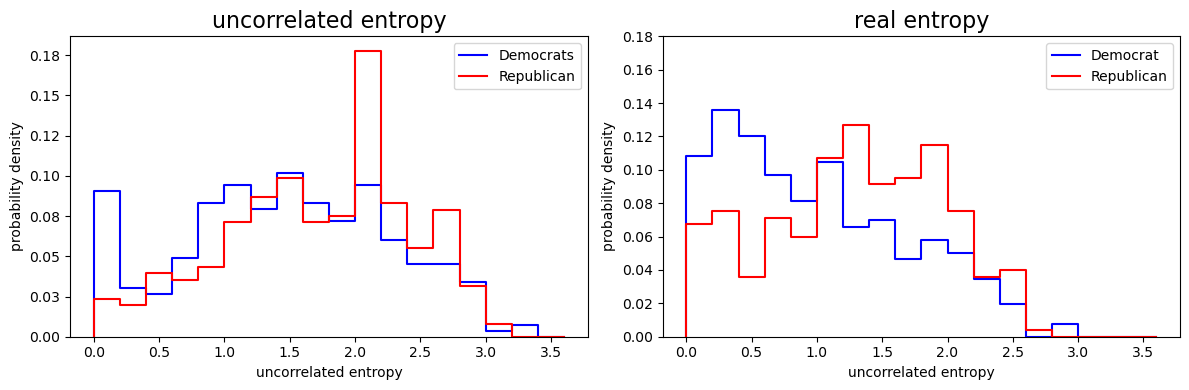

In [203]:
# two plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

bins = np.append(bins, bins[-1] + (bins[1] - bins[0]))

axes[0].step(
    bins[:-1],
    values_uncor_d[:-1],
    label="Democrats",
    color="blue",
)

axes[0].step(
    bins[:-1],
    values_uncor_r[:-1],
    label="Republican",
    color="red",
)


axes[0].set_title("uncorrelated entropy", fontsize=16)
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")
axes[0].set_ylim(bottom=0)
axes[0].legend()

axes[1].step(
    bins[:-1],
    values_real_d[:-1],
    label="Democrat",
    color="blue",
)

axes[1].step(
    bins[:-1],
    values_real_r[:-1],
    label="Republican",
    color="red",
)

axes[1].set_title("real entropy", fontsize=16)
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("uncorrelated entropy")
axes[1].set_ylim(bottom=0)
axes[1].legend()
axes[1].set_ylim(0, 0.18)


# keep only two decimal numbers
axes[0].yaxis.set_major_formatter(formatter)
axes[1].yaxis.set_major_formatter(formatter)


plt.tight_layout()

In [36]:
threshold_2 = data[
    data["top_score"] >= 0.2
]  # from 459.728 to 457.609  # 517 politicians (1 is filtered away)
threshold_4 = data[
    data["top_score"] >= 0.4
]  # from 459.728 to 442.854  # 516 politicians (2 is filtered away)

## Threshold plots

In [216]:
values_uncor_2, bins = np.histogram(
    data_un["uncor entropy >=2"], bins=bins
)
values_uncor_2 = values_uncor_2 / sum(values_uncor_2)

values_uncor_4, bins = np.histogram(data_un["uncor entropy >=4"], bins=bins)
values_uncor_4 = values_uncor_4 / sum(values_uncor_4)

###################################################################################

values_real_2, bins = np.histogram(
    data_un["real entropy >=2"], bins=bins
)
values_real_2 = values_real_2 / sum(values_real_2)

values_real_4, bins = np.histogram(data_un["real_entropy >=4"], bins=bins)
values_real_4 = values_real_4 / sum(values_real_4)

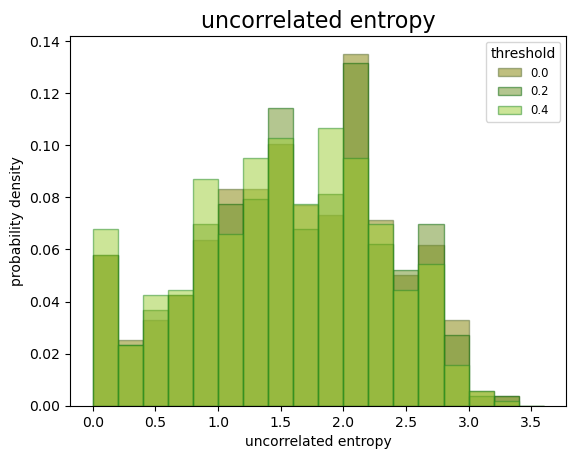

In [113]:
plt.bar(
    bins[:-1],
    values_uncor,
    align="edge",
    width=bins[1] - bins[0],
    label="0.0",
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)

plt.bar(
    bins[:-1],
    values_uncor_2,
    align="edge",
    width=bins[1] - bins[0],
    label="0.2",
    alpha=0.5,
    color="olivedrab",
    edgecolor="darkgreen",
)

plt.bar(
    bins[:-1],
    values_uncor_4,
    align="edge",
    width=bins[1] - bins[0],
    label="0.4",
    color="yellowgreen",
    alpha=0.5,
    edgecolor="forestgreen",
)

plt.title("uncorrelated entropy", fontsize=16)
#plt.legend()
legend = plt.legend( fontsize="small", fancybox=True)
legend.set_title("threshold")
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.show()

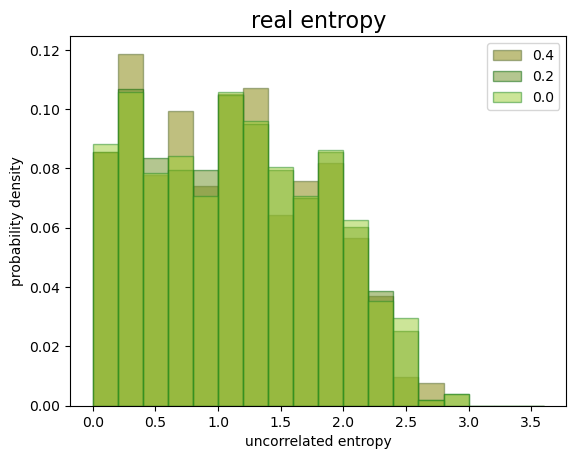

In [64]:
plt.bar(
    bins[:-1],
    values_real_4,
    align="edge",
    width=bins[1] - bins[0],
    label="0.4",
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)

plt.bar(
    bins[:-1],
    values_real_2,
    align="edge",
    width=bins[1] - bins[0],
    label="0.2",
    alpha=0.5,
    color="olivedrab",
    edgecolor="darkgreen",
)

plt.bar(
    bins[:-1],
    values_real,
    align="edge",
    width=bins[1] - bins[0],
    label="0.0",
    color="yellowgreen",
    alpha=0.5,
    edgecolor="forestgreen",
)

plt.title("real entropy", fontsize=16)
plt.legend()
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.show()

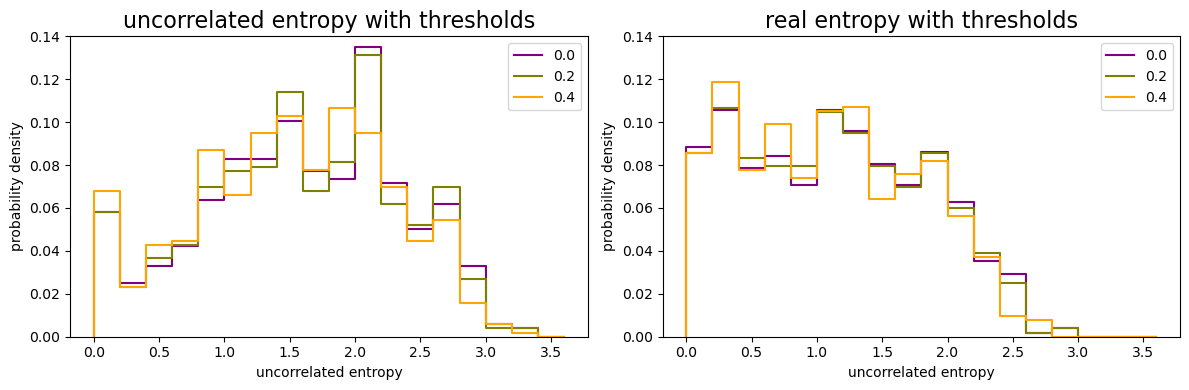

In [215]:
# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Insert 0 at the start of the data arrays
values_real_0 = np.insert(values_real, 0, 0)
values_real_0 = np.append(values_real_0, 0)

values_real_2_0 = np.insert(values_real_2, 0, 0)
values_real_2_0 = np.append(values_real_2_0, 0)

values_real_4_0 = np.insert(values_real_4, 0, 0)
values_real_4_0 = np.append(values_real_4_0, 0)


values_uncor_0 = np.insert(values_uncor, 0, 0)
values_uncor_0 = np.append(values_uncor_0, 0)

values_uncor_2_0 = np.insert(values_uncor_2, 0, 0)
values_uncor_2_0 = np.append(values_uncor_2_0, 0)

values_uncor_4_0 = np.insert(values_uncor_4, 0, 0)
values_uncor_4_0 = np.append(values_uncor_4_0, 0)

bins = np.append(bins, bins[-1] + (bins[1] - bins[0]))


# Plot on the first subplot (axes[0])
axes[0].step(
    bins[:-1],
    values_uncor_0[:-1],  # Slice values_real_4_0 to match bins[:-1]
    label="0.0",
    color="purple",
)

axes[0].step(
    bins[:-1],
    values_uncor_2_0[:-1],  # Slice values_real_2_0 to match bins[:-1]
    label="0.2",
    color="olive",
)

axes[0].step(
    bins[:-1],
    values_uncor_4_0[:-1],  # Slice values_real_0 to match bins[:-1]
    label="0.4",
    color="orange",
)

axes[0].set_title("uncorrelated entropy with thresholds", fontsize=16)
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")
axes[0].set_ylim(0, 0.14)
axes[0].legend()

axes[1].step(
    bins[:-1],
    values_real_0[:-1],  # Slice values_real_4_0 to match bins[:-1]
    label="0.0",
    color="purple",
)

axes[1].step(
    bins[:-1],
    values_real_2_0[:-1],  # Slice values_real_2_0 to match bins[:-1]
    label="0.2",
    color="olive",
)

axes[1].step(
    bins[:-1],
    values_real_4_0[:-1],  # Slice values_real_0 to match bins[:-1]
    label="0.4",
    color="orange",
)

# Set the title, labels, and legend for the first subplot
axes[1].set_title("real entropy with thresholds", fontsize=16)
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("uncorrelated entropy")
axes[1].set_ylim(0, 0.14)
axes[1].legend()

plt.tight_layout()  # Adjust the layout to avoid overlap
plt.show()

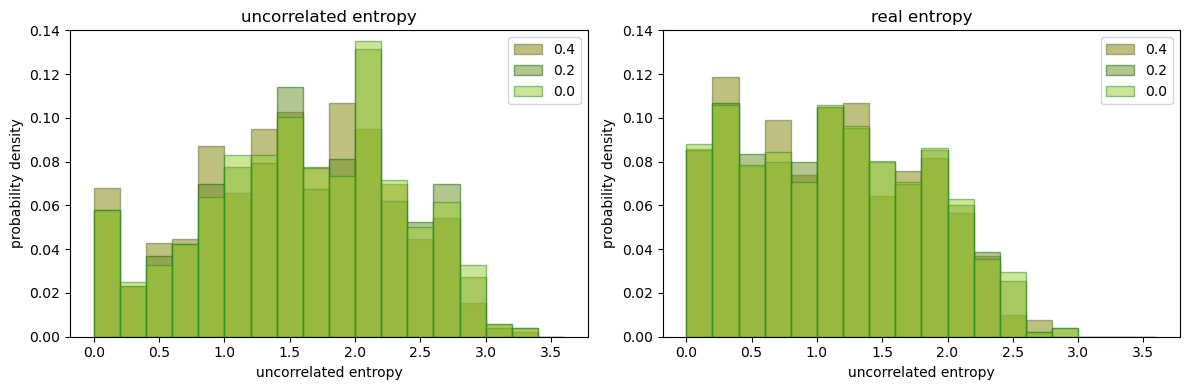

In [81]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].bar(
    bins[:-1],
    values_uncor_4,
    align="edge",
    width=bins[1] - bins[0],
    label="0.4",
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)
axes[0].bar(
    bins[:-1],
    values_uncor_2,
    align="edge",
    width=bins[1] - bins[0],
    label="0.2",
    alpha=0.5,
    color="olivedrab",
    edgecolor="darkgreen",
)

axes[0].bar(
    bins[:-1],
    values_uncor,
    align="edge",
    width=bins[1] - bins[0],
    label="0.0",
    color="yellowgreen",
    alpha=0.5,
    edgecolor="forestgreen",
)

axes[0].set_title("uncorrelated entropy")
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")
axes[0].set_ylim(0, 0.14)
axes[0].legend()

axes[1].bar(
    bins[:-1],
    values_real_4,
    align="edge",
    width=bins[1] - bins[0],
    label="0.4",
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)
axes[1].bar(
    bins[:-1],
    values_real_2,
    align="edge",
    width=bins[1] - bins[0],
    label="0.2",
    alpha=0.5,
    color="olivedrab",
    edgecolor="darkgreen",
)

axes[1].bar(
    bins[:-1],
    values_real,
    align="edge",
    width=bins[1] - bins[0],
    label="0.0",
    color="yellowgreen",
    alpha=0.5,
    edgecolor="forestgreen",
)
axes[1].set_title("real entropy")
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("uncorrelated entropy")
axes[1].set_ylim(0, 0.14)
axes[1].legend()

plt.tight_layout()
plt.show()

In [230]:
values_uncor_d_th2, bins = np.histogram(df1["uncor entropy >=2"], bins=bins)
values_uncor_d_th2 = values_uncor_d_th2 / sum(values_uncor_d_th2)

values_uncor_d_th4, bins = np.histogram(df1["uncor entropy >=4"], bins=bins)
values_uncor_d_th4 = values_uncor_d_th4 / sum(values_uncor_d_th4)

values_uncor_r_th2, bins = np.histogram(df2["uncor entropy >=2"], bins=bins)
values_uncor_r_th2 = values_uncor_r_th2 / sum(values_uncor_r_th2)

values_uncor_r_th4, bins = np.histogram(df2["uncor entropy >=4"], bins=bins)
values_uncor_r_th4 = values_uncor_r_th4 / sum(values_uncor_r_th4)

#########################################################################################

values_real_d_th2, bins = np.histogram(df1["real entropy >=2"], bins=bins)
values_real_d_th2 = values_real_d_th2 / sum(values_real_d_th2)

values_real_d_th4, bins = np.histogram(df1["real_entropy >=4"], bins=bins)
values_real_d_th4 = values_real_d_th4 / sum(values_real_d_th4)

values_real_r_th2, bins = np.histogram(df2["real entropy >=2"], bins=bins)
values_real_r_th2 = values_real_r_th2 / sum(values_real_r_th2)

values_real_r_th4, bins = np.histogram(df2["real_entropy >=4"], bins=bins)
values_real_r_th4 = values_real_r_th4 / sum(values_real_r_th4)

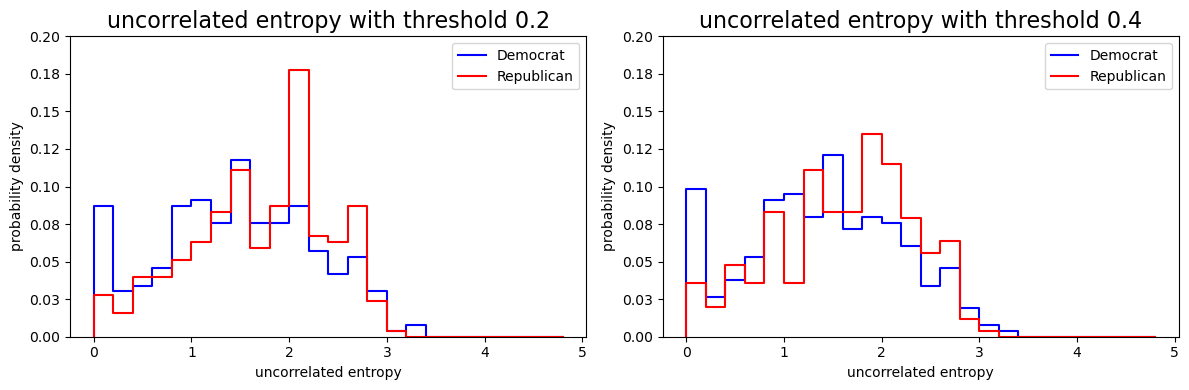

In [229]:
# Create the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Insert 0 at the start of the data arrays
values_uncor_d_th2 = np.insert(values_uncor_d_th2, 0, 0)
values_uncor_d_th2 = np.append(values_uncor_d_th2, 0)

values_uncor_r_th2 = np.insert(values_uncor_r_th2, 0, 0)
values_uncor_r_th2 = np.append(values_uncor_r_th2, 0)


values_uncor_d_th4 = np.insert(values_uncor_d_th4, 0, 0)
values_uncor_d_th4 = np.append(values_uncor_d_th4, 0)

values_uncor_r_th4 = np.insert(values_uncor_r_th4, 0, 0)
values_uncor_r_th4 = np.append(values_uncor_r_th4, 0)

bins = np.append(bins, bins[-1] + (bins[1] - bins[0]))
# Plot on the first subplot (axes[0])
axes[0].step(
    bins[:-1],
    values_uncor_d_th2[:-1],  # Slice values_real_4_0 to match bins[:-1]
    label="Democrat",
    color="blue",
)

axes[0].step(
    bins[:-1],
    values_uncor_r_th2[:-1],  # Slice values_real_2_0 to match bins[:-1]
    label="Republican",
    color="red",
)


axes[0].set_title("uncorrelated entropy with threshold 0.2", fontsize=16)
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")
axes[0].set_ylim(bottom=0)
axes[0].legend()

axes[1].step(
    bins[:-1],
    values_uncor_d_th4[:-1],  # Slice values_real_4_0 to match bins[:-1]
    label="Democrat",
    color="blue",
)

axes[1].step(
    bins[:-1],
    values_uncor_r_th4[:-1],  # Slice values_real_2_0 to match bins[:-1]
    label="Republican",
    color="red",
)


# Set the title, labels, and legend for the first subplot
axes[1].set_title("uncorrelated entropy with threshold 0.4", fontsize=16)
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("uncorrelated entropy")
axes[1].legend()
axes[0].set_ylim(0, 0.20)
axes[1].set_ylim(0, 0.20)

axes[0].yaxis.set_major_formatter(formatter)
axes[1].yaxis.set_major_formatter(formatter)

plt.tight_layout()

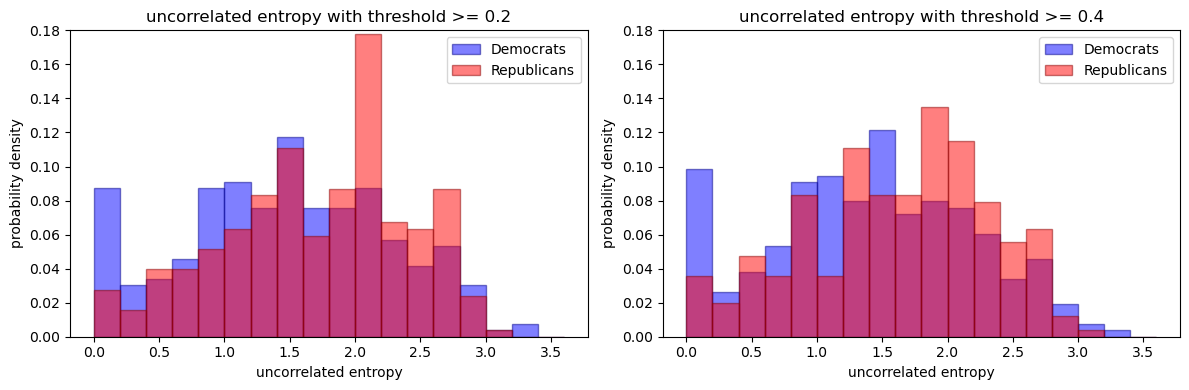

In [131]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].bar(
    bins[:-1],
    values_uncor_d_th2,
    align="edge",
    width=bins[1] - bins[0],
    label="Democrats",
    alpha=0.5,
    color="blue",
    edgecolor="darkblue",
)

axes[0].bar(
    bins[:-1],
    values_uncor_r_th2,
    align="edge",
    width=bins[1] - bins[0],
    label="Republicans",
    color="red",
    alpha=0.5,
    edgecolor="darkred",
)
axes[0].set_title("uncorrelated entropy with threshold >= 0.2")
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")
axes[0].legend()


axes[1].bar(
    bins[:-1],
    values_uncor_d_th4,
    align="edge",
    width=bins[1] - bins[0],
    label="Democrats",
    color="blue",
    alpha=0.5,
    edgecolor="darkblue",
)

axes[1].bar(
    bins[:-1],
    values_uncor_r_th4,
    align="edge",
    width=bins[1] - bins[0],
    label="Republicans",
    color="red",
    alpha=0.5,
    edgecolor="darkred",
)
axes[1].set_title("uncorrelated entropy with threshold >= 0.4")
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("uncorrelated entropy")
axes[1].set_ylim(0, 0.18)
axes[0].set_ylim(0, 0.18)

axes[1].legend()


plt.tight_layout()
plt.show()

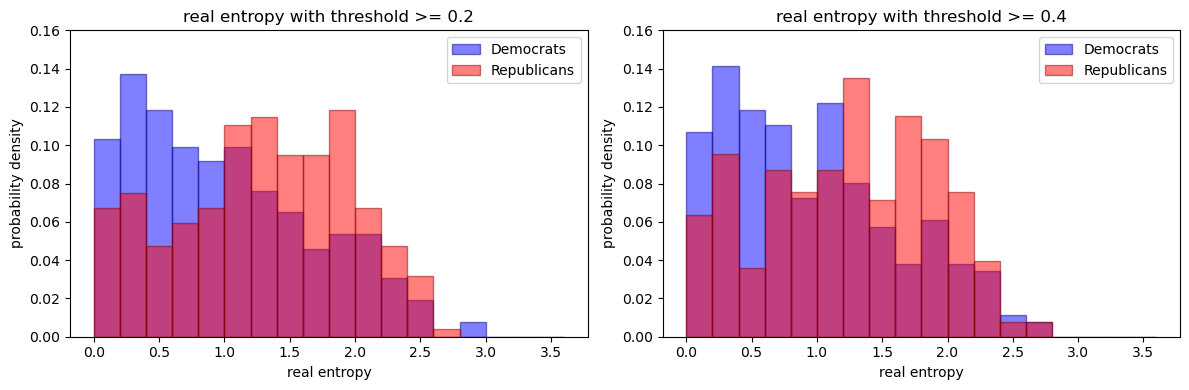

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].bar(
    bins[:-1],
    values_real_d_th2,
    align="edge",
    width=bins[1] - bins[0],
    label="Democrats",
    alpha=0.5,
    color="blue",
    edgecolor="darkblue",
)

axes[0].bar(
    bins[:-1],
    values_real_r_th2,
    align="edge",
    width=bins[1] - bins[0],
    label="Republicans",
    color="red",
    alpha=0.5,
    edgecolor="darkred",
)
axes[0].set_title("real entropy with threshold >= 0.2")
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("real entropy")

axes[1].bar(
    bins[:-1],
    values_real_d_th4,
    align="edge",
    width=bins[1] - bins[0],
    label="Democrats",
    color="blue",
    alpha=0.5,
    edgecolor="darkblue",
)

axes[1].bar(
    bins[:-1],
    values_real_r_th4,
    align="edge",
    width=bins[1] - bins[0],
    label="Republicans",
    color="red",
    alpha=0.5,
    edgecolor="darkred",
)
axes[1].set_title("real entropy with threshold >= 0.4")
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("real entropy")
axes[0].set_ylim(0, 0.16)
axes[1].set_ylim(0, 0.16)
axes[1].legend()
axes[0].legend()


plt.tight_layout()
plt.show()

## special case for calculating real-entropy for Sanders and Ocasio-Cortez

In [3]:
data_org = pd.read_csv("mandagsmagi.csv", index_col=0)

In [3]:
# filtering data
id_B = [124955570892789, 1316372698453411]  # Sanders page_id
al = data_org[~data_org["page_id"].isin(id_B)]

In [5]:
# Step 1: Filter data for the specific page_id
filtered_data_a = data_org[data_org["page_id"].isin([1316372698453411])]

# Step 2: Calculate the midpoint of the filtered data
midpoint = len(filtered_data_a) // 2
quarterpoint = len(filtered_data_a) // 4  # Calculate the quarterpoint for the 4 parts

# Step 3: Split the DataFrame into two halves
df_part1 = filtered_data_a.iloc[:midpoint]  # First half
df_part2 = filtered_data_a.iloc[midpoint:]  # Second half

# Step 4: Further split each half into two parts
df_part1a = df_part1.iloc[:quarterpoint]  # First quarter
df_part1b = df_part1.iloc[quarterpoint:]  # Second quarter
df_part2a = df_part2.iloc[:quarterpoint]  # Third quarter
df_part2b = df_part2.iloc[quarterpoint:]  # Fourth quarter

# Step 5: Replace the page_id in each part as needed
df_part1a["page_id"] = df_part1a["page_id"].replace(1316372698453411, 130000000000000)
df_part1b["page_id"] = df_part1b["page_id"].replace(1316372698453411, 130000000000001)
df_part2a["page_id"] = df_part2a["page_id"].replace(1316372698453411, 130000000000002)
df_part2b["page_id"] = df_part2b["page_id"].replace(1316372698453411, 130000000000003)

# Now you have 4 parts: df_part1a, df_part1b, df_part2a, df_part2b

/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_21233/130153947.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part1a["page_id"] = df_part1a["page_id"].replace(1316372698453411, 130000000000000)
/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_21233/130153947.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part1b["page_id"] = df_part1b["page_id"].replace(1316372698453411, 130000000000001)
/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_21233/130153947.py:21: 

In [7]:
# Step 1: Filter data for the specific page_id
filtered_data_b = data_org[data_org["page_id"].isin([124955570892789])]

# Step 2: Calculate the midpoint of the filtered data
midpoint1 = len(filtered_data_b) // 2
quarterpoint1 = len(filtered_data_b) // 4  # Calculate the quarterpoint for the 4 parts

# Step 3: Split the DataFrame into two halves
df_part11 = filtered_data_b.iloc[:midpoint1]  # First half
df_part22 = filtered_data_b.iloc[midpoint1:]  # Second half

# Step 4: Further split each half into two parts
df_part1aa = df_part11.iloc[:quarterpoint1]  # First quarter
df_part1bb = df_part11.iloc[quarterpoint1:]  # Second quarter
df_part2aa = df_part22.iloc[:quarterpoint1]  # Third quarter
df_part2bb = df_part22.iloc[quarterpoint1:]  # Fourth quarter

# Step 5: Replace the page_id in each part as needed
df_part1aa["page_id"] = df_part1aa["page_id"].replace(124955570892789, 120000000000000)
df_part1bb["page_id"] = df_part1bb["page_id"].replace(124955570892789, 120000000000001)
df_part2aa["page_id"] = df_part2aa["page_id"].replace(124955570892789, 120000000000002)
df_part2bb["page_id"] = df_part2bb["page_id"].replace(124955570892789, 120000000000003)

# Now you have 4 parts: df_part1a, df_part1b, df_part2a, df_part2b

/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_21233/4268955898.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part1aa["page_id"] = df_part1aa["page_id"].replace(124955570892789, 120000000000000)
/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_21233/4268955898.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part1bb["page_id"] = df_part1bb["page_id"].replace(124955570892789, 120000000000001)
/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_21233/4268955898.py

In [35]:
lol = data_org[data_org["page_id"] > 1116372698453411]

In [27]:
bern1["page_id"] = bern1["page_id"].replace(1316372698453411, 131637000000000)
bern2["page_id"] = bern2["page_id"].replace(1316372698453411, 131637000000001)

In [12]:
combined_df_a = pd.concat([df_part1a, df_part2a, df_part1b, df_part2b], ignore_index=True)

In [14]:
combined_df_b = pd.concat(
    [df_part1aa, df_part2aa, df_part1bb, df_part2bb], ignore_index=True
)

In [17]:
combined_df_a.to_csv("alex4.csv")

In [18]:
combined_df_b.to_csv("bern4.csv")

In [234]:
id_B = [124955570892789, 1316372698453411]
filtered_data = data_org[~data_org["page_id"].isin(id_B)]

In [13]:
filtered_data_a = data_org[data_org["page_id"].isin([1316372698453411])]
midpoint = len(filtered_data_a) // 2

# Split the DataFrame into two parts
df_part1 = filtered_data_a.iloc[:midpoint]
df_part2 = filtered_data_a.iloc[midpoint:]

df_part1["page_id"] = df_part1["page_id"].replace(1316372698453411, 130000000000000)
df_part2["page_id"] = df_part2["page_id"].replace(1316372698453411, 130000000000001)

/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_1677/3447034453.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part1["page_id"] = df_part1["page_id"].replace(1316372698453411, 130000000000000)
/var/folders/cr/2b4bjd0d6cscnr8h_66vmrqm0000gn/T/ipykernel_1677/3447034453.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part2["page_id"] = df_part2["page_id"].replace(1316372698453411, 130000000000001)


In [7]:
data_org.tail(5)

,Unnamed: 0,ad_creation_time,ad_creative_body,spend,impressions,delivery_by_region,demographic_distribution,page_id,page_name,bylines,...,spend_lo,spend_hi,impressions_lo,impressions_hi,party,state,labels,scores,top_label,top_score
459723,459723,2018-08-30,It’s Mike’s Birthday and he wants a clean plan...,49.5,499.5,"[{'percentage': '1', 'region': 'Pennsylvania'}]","[{'percentage': '0.002494', 'age': '18-24', 'g...",174750213023790,"Mike Doyle for PA Representative, 170th District",Friends To Elect Mike Doyle,...,0,99,0,999,Democrat,PA,"['Climate', 'Call for Action', 'Other', 'Socia...","[0.5919962525367737, 0.4074147939682007, 0.000...",Climate,0.591996
459724,459724,2018-08-30,"Send Mike a ""birthday"" gift for his 41st birth...",49.5,1499.5,"[{'percentage': '1', 'region': 'Pennsylvania'}]","[{'percentage': '0.001106', 'age': '18-24', 'g...",174750213023790,"Mike Doyle for PA Representative, 170th District",Friends To Elect Mike Doyle,...,0,99,1000,1999,Democrat,PA,"['Call for Action', 'Other', 'Law and Crime', ...","[0.6639231443405151, 0.12551826238632202, 0.02...",Call for Action,0.663923
459725,459725,2018-08-24,Mike's turning 41! Help him celebrate his birt...,49.5,499.5,"[{'percentage': '1', 'region': 'Pennsylvania'}]","[{'percentage': '0.003205', 'age': '18-24', 'g...",174750213023790,"Mike Doyle for PA Representative, 170th District",Friends To Elect Mike Doyle,...,0,99,0,999,Democrat,PA,"['Call for Action', 'Other', 'Education and Cu...","[0.9912557601928711, 0.0022203035186976194, 0....",Call for Action,0.991256
459726,459726,2018-08-22,Hope to see everyone tonight!,49.5,499.5,"[{'percentage': '1', 'region': 'Pennsylvania'}]","[{'percentage': '0.066806', 'age': '25-34', 'g...",174750213023790,"Mike Doyle for PA Representative, 170th District",Friends To Elect Mike Doyle,...,0,99,0,999,Democrat,PA,"['Other', 'Call for Action', 'Education and Cu...","[0.2518262267112732, 0.18089647591114044, 0.08...",Other,0.251826
459727,459727,2021-10-08,I am committed to helping middle-class familie...,449.5,12499.5,"[{'percentage': '1', 'region': 'California'}]","[{'percentage': '0.001772', 'age': '65+', 'gen...",182567716746,Congressman John Garamendi,Office of Congressman John Garamendi,...,400,499,10000,14999,Democrat,CA,"['Economy', 'Call for Action', 'Other', 'Labor...","[0.97571861743927, 0.01566304825246334, 0.0026...",Economy,0.975719


In [13]:
filtered_data_b = data_org[data_org["page_id"].isin([182567716746])]  # 124955570892789
midpoint = len(filtered_data_b) // 2

# Split the DataFrame into two parts
df_part1_b = filtered_data_b.iloc[:midpoint]
df_part2_b = filtered_data_b.iloc[midpoint:]

df_part1_b["page_id"] = df_part1_b["page_id"].replace(124955570892789, 120000000000000)
df_part2_b["page_id"] = df_part2_b["page_id"].replace(124955570892789, 120000000000001)

In [15]:
filtered_data_b.to_csv("test.csv")

In [14]:
filtered_data_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1 entries, 459727 to 459727
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                1 non-null      int64  
 1   ad_creation_time          1 non-null      object 
 2   ad_creative_body          1 non-null      object 
 3   spend                     1 non-null      float64
 4   impressions               1 non-null      float64
 5   delivery_by_region        1 non-null      object 
 6   demographic_distribution  1 non-null      object 
 7   page_id                   1 non-null      int64  
 8   page_name                 1 non-null      object 
 9   bylines                   1 non-null      object 
 10  id                        1 non-null      int64  
 11  spend_lo                  1 non-null      int64  
 12  spend_hi                  1 non-null      int64  
 13  impressions_lo            1 non-null      int64  
 14  impressio

In [236]:
combined_df = pd.concat([filtered_data, df_part2_b], ignore_index=True)

## Merge entropy calculations into org. dataframe

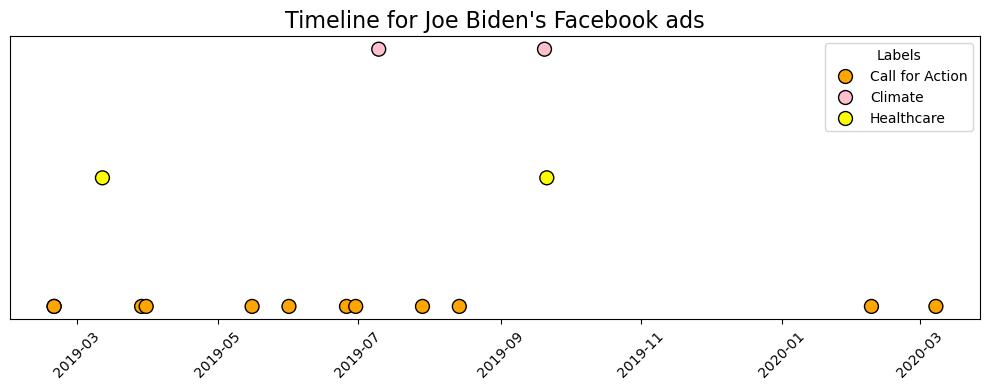

In [230]:
# Step 3: Create a timeline plot
plt.figure(figsize=(10, 4))

# Plot each vegetable on the timeline
# plt.scatter(filtered_df["time"], filtered_df["top_label"], color="green")

col = {
    "Call for Action": "orange",
    "Climate": "pink",
    "Healthcare": "yellow",
}

colors = filtered_df["top_label"].map(col)
# Plot each vegetable on the timeline
plt.scatter(
    filtered_df["time"],
    filtered_df["top_label"],
    color=colors,
    edgecolor="black",
    s=100,
    linewidth=1,
)

# Remove y-axis labels and ticks
plt.yticks([])

# Add a legend for clarity
handles = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=col[label],
        markersize=10,
        markeredgecolor="black",
        markeredgewidth=1,
    )
    for label in col.keys()
]
plt.legend(handles, col.keys(), title="Labels", loc="upper right")


# Add labels and title
plt.title(f"Timeline for Joe Biden's Facebook ads", fontsize=16)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

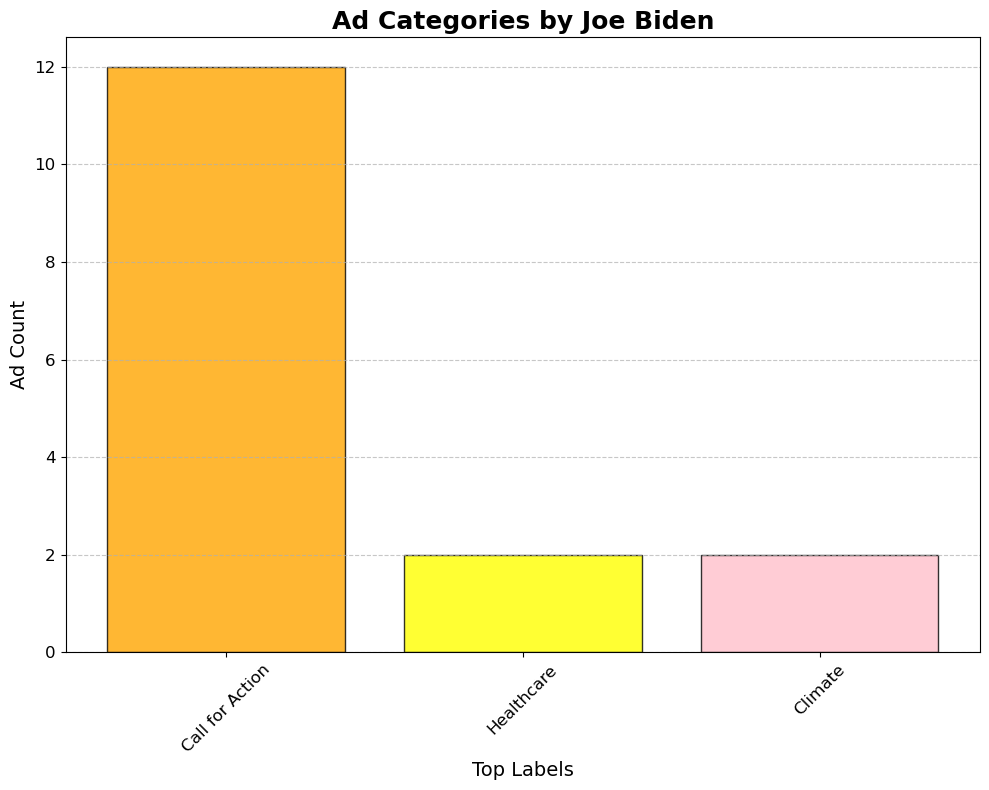

In [229]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 3: Create a timeline plot
plt.figure(figsize=(10, 8))

# Define colors for each category
col = {
    "Call for Action": "orange",
    "Climate": "pink",
    "Healthcare": "yellow",
}

# Create a count for each category
label_counts = filtered_df["top_label"].value_counts()

# Plot the histogram using bar chart style for discrete categories
bars = plt.bar(
    label_counts.index,
    label_counts.values,
    color=[col[label] for label in label_counts.index],
    edgecolor="black",
    alpha=0.8,
)

# Add labels and title
plt.title(f"Ad Categories by Joe Biden", fontsize=18, fontweight="bold")
plt.ylabel("Ad Count", fontsize=14)
plt.xlabel("Top Labels", fontsize=14)

# Add gridlines
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Customize ticks
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
## Archive

In [84]:
# Check if the row with id 609 exists and fill missing entropy with 0.9
data_un.loc[data_un["page_id"] == 124955570892789, "uncor_entropy"] = data_un.loc[
    data_un["page_id"] == 124955570892789, "uncor_entropy"
].fillna(0.11971795767098171)

In [83]:
data_org = pd.read_csv(
    "/Users/sofiepalmuskronborg/Library/CloudStorage/OneDrive-ITU/ITU/Thesis/data_threshold_entropy.csv"
)
data_un = data_org.drop_duplicates(
    subset=["page_id"]
)  # narrowing down to 518 politicians

In [88]:
# Check if the row with id 609 exists and fill missing entropy with 0.9
data_un.loc[data_un["page_id"] == 1316372698453411, "uncor_entropy"] = data_un.loc[
    data_un["page_id"] == 124955570892789, "uncor_entropy"
].fillna(0.07463092294975433)

In [ ]:
## acrhive plots

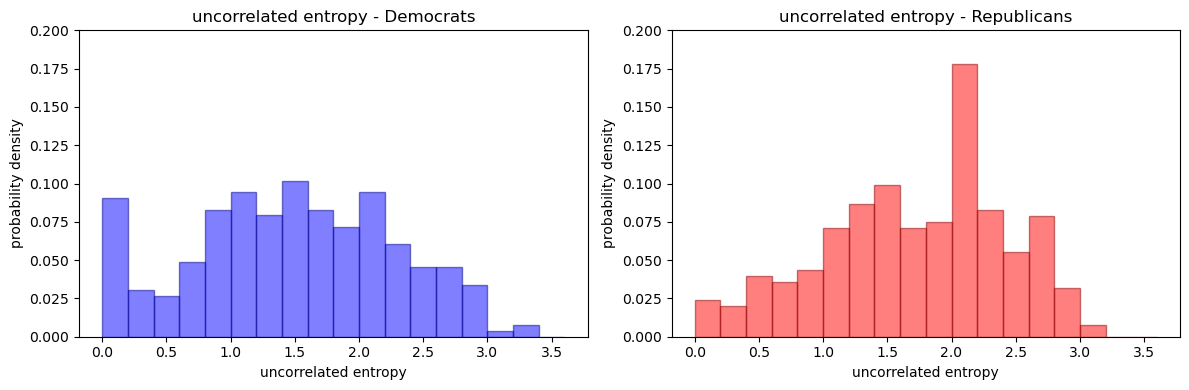

In [ ]:
df1 = data_un[data_un["party"] == "Democrat"]
df2 = data_un[data_un["party"] == "Republican"]

values_uncor_d, bins = np.histogram(
    df1["uncor entropy"], bins=np.linspace(0, 3.6, 19)
)
values_uncor_d = values_uncor_d / sum(values_uncor_d)

# Calculate and normalize values for real entropy
values_uncor_r, bins = np.histogram(
    df2["uncor entropy"], bins=bins
)
values_uncor_r = values_uncor_r / sum(values_uncor_r)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].bar(
    bins[:-1],
    values_uncor_d,
    align="edge",
    width=bins[1] - bins[0],
    alpha=0.5,
    color="blue",
    edgecolor="darkblue",
)
axes[0].set_title("uncorrelated entropy - Democrats")
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("uncorrelated entropy")

axes[1].bar(
    bins[:-1],
    values_uncor_r,
    align="edge",
    width=bins[1] - bins[0],
    alpha=0.5,
    color="red",
    edgecolor="darkred",
)

max_y = max(max(values_uncor_r), max(values_uncor_d))
y_limit = round(max_y + 0.05, 2)

axes[1].set_title("uncorrelated entropy - Republicans")
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("uncorrelated entropy")
axes[0].set_ylim(0, 0.2)
axes[1].set_ylim(0, 0.2)

plt.tight_layout()
plt.show()

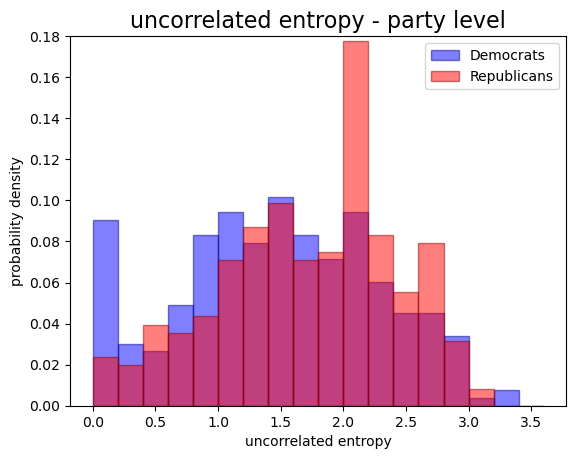

In [ ]:
plt.bar(
    bins[:-1],
    values_uncor_d, 
    align='edge',
    width=bins[1] - bins[0],
    label="Democrats",
    alpha=0.5,
    color="blue",
    edgecolor="darkblue",
)

plt.bar(
    bins[:-1],
    values_uncor_r,
    align="edge",
    width=bins[1] - bins[0],
    label="Republicans",
    color="red",
    alpha=.5,
    edgecolor="darkred",
)

plt.title("uncorrelated entropy - party level", fontsize=16)
plt.legend()
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.ylim(0, 0.18) 
plt.show()

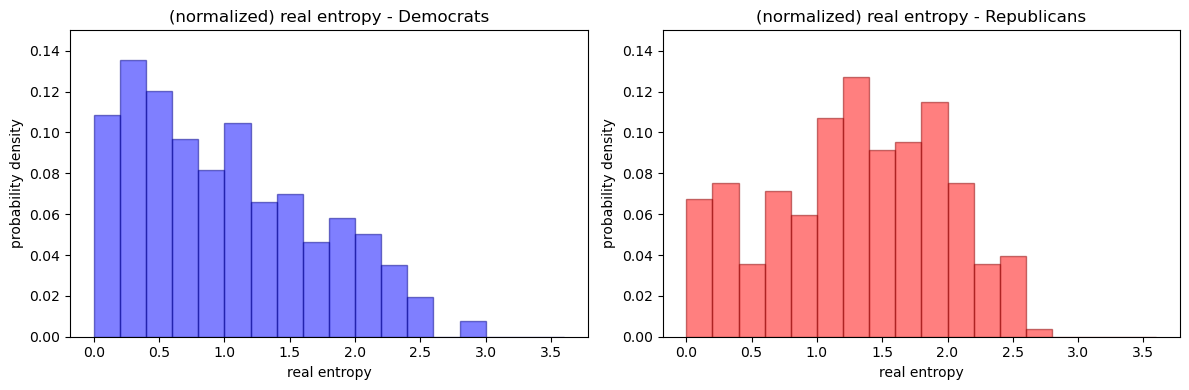

In [191]:
values_real_d, bins = np.histogram(df1["real entropy"], bins=np.linspace(0, 3.6, 19))
values_real_d = values_real_d / sum(values_real_d)

# Calculate and normalize values for real entropy
values_real_r, bins = np.histogram(df2["real entropy"], bins=bins)
values_real_r = values_real_r / sum(values_real_r)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].bar(
    bins[:-1],
    values_real_d,
    align="edge",
    width=bins[1] - bins[0],
    alpha=0.5,
    color="blue",
    edgecolor="darkblue",
)
axes[0].set_title("(normalized) real entropy - Democrats")
axes[0].set_ylabel("probability density")
axes[0].set_xlabel("real entropy")

axes[1].bar(
    bins[:-1],
    values_real_r,
    align="edge",
    width=bins[1] - bins[0],
    alpha=0.5,
    color="red",
    edgecolor="darkred",
)


axes[1].set_title("(normalized) real entropy - Republicans")
axes[1].set_ylabel("probability density")
axes[1].set_xlabel("real entropy")
axes[0].set_ylim(0, 0.15)
axes[1].set_ylim(0, 0.15)

plt.tight_layout()
plt.show()

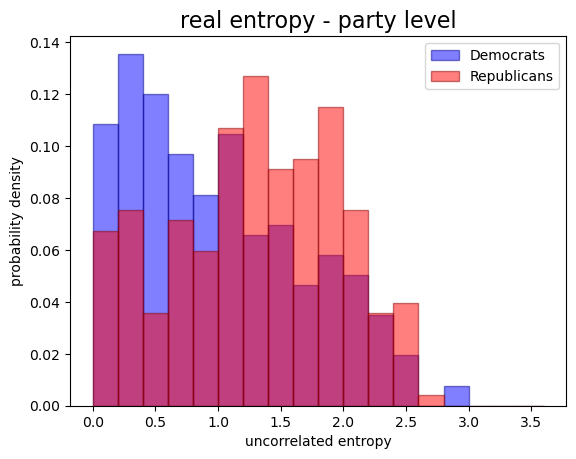

In [190]:
plt.bar(
    bins[:-1],
    values_real_d,
    align="edge",
    width=bins[1] - bins[0],
    label="Democrats",
    alpha=0.5,
    color="blue",
    edgecolor="darkblue",
)

plt.bar(
    bins[:-1],
    values_real_r,
    align="edge",
    width=bins[1] - bins[0],
    label="Republicans",
    alpha=0.5,
    color="red",
    edgecolor="darkred",
)

plt.title("real entropy - party level", fontsize=16)
plt.legend()
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.show()

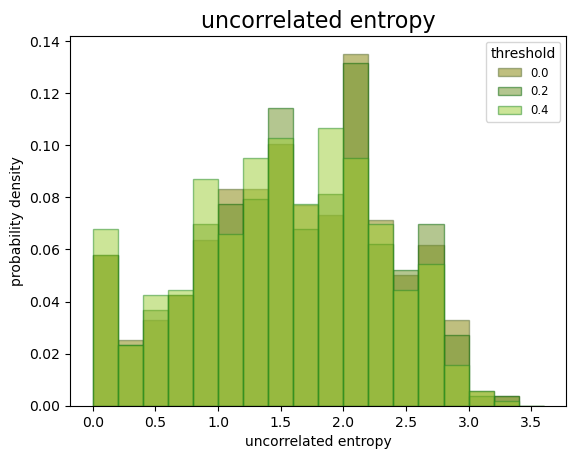

In [ ]:
plt.bar(
    bins[:-1],
    values_uncor,
    align="edge",
    width=bins[1] - bins[0],
    label="0.0",
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)

plt.bar(
    bins[:-1],
    values_uncor_2,
    align="edge",
    width=bins[1] - bins[0],
    label="0.2",
    alpha=0.5,
    color="olivedrab",
    edgecolor="darkgreen",
)

plt.bar(
    bins[:-1],
    values_uncor_4,
    align="edge",
    width=bins[1] - bins[0],
    label="0.4",
    color="yellowgreen",
    alpha=0.5,
    edgecolor="forestgreen",
)

plt.title("uncorrelated entropy", fontsize=16)
#plt.legend()
legend = plt.legend( fontsize="small", fancybox=True)
legend.set_title("threshold")
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.show()

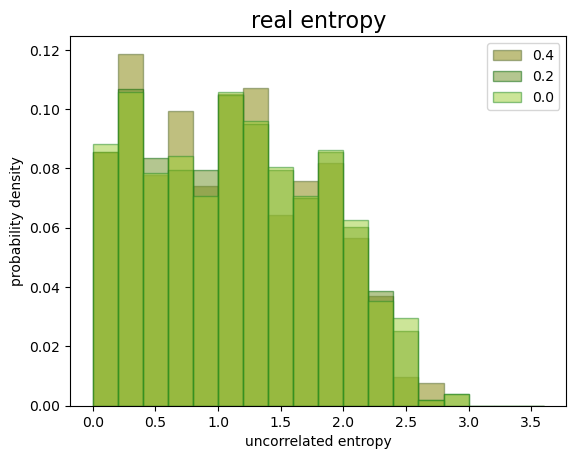

In [ ]:
plt.bar(
    bins[:-1],
    values_real_4,
    align="edge",
    width=bins[1] - bins[0],
    label="0.4",
    alpha=0.5,
    color="olive",
    edgecolor="darkolivegreen",
)

plt.bar(
    bins[:-1],
    values_real_2,
    align="edge",
    width=bins[1] - bins[0],
    label="0.2",
    alpha=0.5,
    color="olivedrab",
    edgecolor="darkgreen",
)

plt.bar(
    bins[:-1],
    values_real,
    align="edge",
    width=bins[1] - bins[0],
    label="0.0",
    color="yellowgreen",
    alpha=0.5,
    edgecolor="forestgreen",
)

plt.title("real entropy", fontsize=16)
plt.legend()
plt.ylabel("probability density")
plt.xlabel("uncorrelated entropy")
plt.show()